In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 644
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

DATASET_DIR_NAME = "dataset\set01\\03_pair"
SAMPLE_DATASET_NAME = "pair_train"
ACTUAL_DATASET_NAME = "pair_test"

MODEL_DIR_NAME = "dataset\set01\\03_pair"
MODEL_NAME = "model_" + "set01_03_pair"

RESULT_DIR_NAME = "dataset\set01\\03_pair"
RESULT_NAME = "result_" + "set01_03_pair"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\03_pair
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\03_pair
Decompress 7z file to: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\03_pair\pair_train.7z


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR.1,T9-NG|VAR.1,T9-I|SD.1,T9-PF|SD.1,T9-RF|SD.1,T9-NG|SD.1,T10-I|0+9.1,T10-PF|0+9.1,T10-RF|0+9.1,T10-NG|0+9.1
0,andy,3,mad wabble,0.155289,-0.063554,0.091736,0.079413,0.234703,0.142967,-0.070407,...,0.000004,0.000012,0.016395,0.021845,0.002045,0.003405,0.592526,0.737618,0.767610,0.912702
1,andy,3,mad wabble,0.155289,-0.063554,0.091736,0.079413,0.234703,0.142967,-0.070407,...,0.000010,0.000076,0.018205,0.006379,0.003111,0.008715,0.825110,0.965556,0.945867,1.086313
2,andy,3,mad wabble,0.155289,-0.063554,0.091736,0.079413,0.234703,0.142967,-0.070407,...,0.009357,0.007031,0.085139,0.072256,0.096733,0.083850,0.902030,1.009710,1.020279,1.127959
3,andy,3,mad wabble,0.155289,-0.063554,0.091736,0.079413,0.234703,0.142967,-0.070407,...,0.000095,0.000527,0.003808,0.017021,0.009740,0.022953,0.606257,0.766546,0.721821,0.882110
4,andy,3,mad wabble,0.155289,-0.063554,0.091736,0.079413,0.234703,0.142967,-0.070407,...,0.000020,0.003119,0.027978,0.032309,0.004435,0.055852,0.831784,1.026330,0.956491,1.151037


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


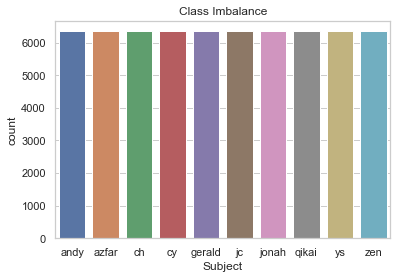

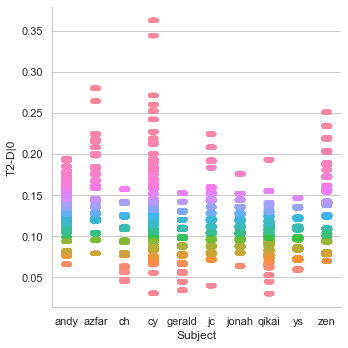

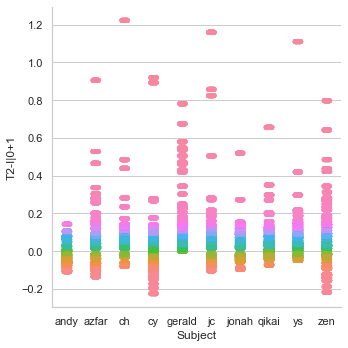

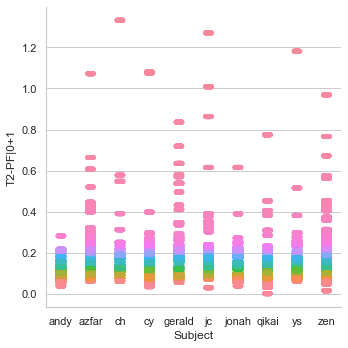

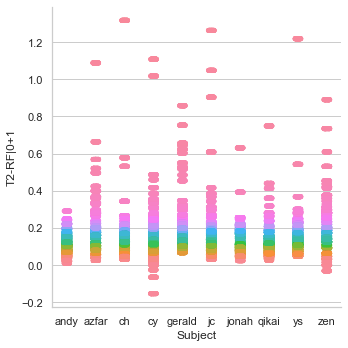

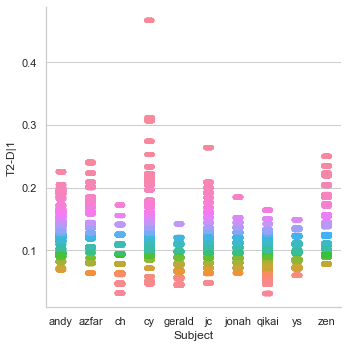

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (63480, 644)
Y | Classes  | Dataset Shape: (63480, 10)
Number of Classes: 10


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (50784, 1, 644)
Y train shape: (50784, 10)
X test shape: (12696, 1, 644)
Y test shape: (12696, 10)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 10 classes.
Epoch 1/200
407/407 [==============================] - 14s 18ms/step - loss: 1.9949 - accuracy: 0.2333
Epoch 2/200
407/407 [==============================] - 7s 18ms/step - loss: 1.5203 - accuracy: 0.3999
Epoch 3/200
407/407 [==============================] - 7s 18ms/step - loss: 1.3001 - accuracy: 0.4862
Epoch 4/200
407/407 [==============================] - 7s 18ms/step - loss: 1.1302 - accuracy: 0.5561
Epoch 5/200
407/407 [==============================] - 7s 18ms/step - loss: 1.0055 - accuracy: 0.6095
Epoch 6/200
407/407 [==============================] - 7s 18ms/step - loss: 0.9451 - accuracy: 0.6332
Epoch 7/200
407/407 [==============================] - 7s 18ms/step - loss: 0.9033 - accuracy: 0.6511
Epoch 8/200
407/407 [==============================] - 7s 18ms/step - loss: 0.8667 - accuracy: 0.6648
Epoch 9/200
407/407 [==============================] - 7s 18ms/step - loss: 0.8525 - accuracy: 0.6706
Epoch 10/200
407/407 [==========================

407/407 [==============================] - 7s 18ms/step - loss: 0.3918 - accuracy: 0.8586
Epoch 81/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3852 - accuracy: 0.8618
Epoch 82/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3804 - accuracy: 0.8646
Epoch 83/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3673 - accuracy: 0.8684
Epoch 84/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3837 - accuracy: 0.8604
Epoch 85/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3845 - accuracy: 0.8613
Epoch 86/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3630 - accuracy: 0.8693
Epoch 87/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3669 - accuracy: 0.8671
Epoch 88/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3655 - accuracy: 0.8669
Epoch 89/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3438 - 

407/407 [==============================] - 7s 18ms/step - loss: 0.2449 - accuracy: 0.9146
Epoch 160/200
407/407 [==============================] - 7s 18ms/step - loss: 0.2574 - accuracy: 0.9127
Epoch 161/200
407/407 [==============================] - 8s 18ms/step - loss: 0.2435 - accuracy: 0.9149
Epoch 162/200
407/407 [==============================] - 7s 18ms/step - loss: 0.2337 - accuracy: 0.9197
Epoch 163/200
407/407 [==============================] - 7s 18ms/step - loss: 0.3032 - accuracy: 0.8967
Epoch 164/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2490 - accuracy: 0.9137
Epoch 165/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2370 - accuracy: 0.9180
Epoch 166/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2301 - accuracy: 0.9203
Epoch 167/200
407/407 [==============================] - 7s 18ms/step - loss: 0.2790 - accuracy: 0.9068
Epoch 168/200
407/407 [==============================] - 8s 18ms/step - loss: 

407/407 [==============================] - 8s 19ms/step - loss: 0.4974 - accuracy: 0.8205
Epoch 38/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4909 - accuracy: 0.8213
Epoch 39/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4906 - accuracy: 0.8251
Epoch 40/200
407/407 [==============================] - 8s 18ms/step - loss: 0.4928 - accuracy: 0.8231
Epoch 41/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4725 - accuracy: 0.8304
Epoch 42/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4726 - accuracy: 0.8298
Epoch 43/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4641 - accuracy: 0.8335
Epoch 44/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4549 - accuracy: 0.8366
Epoch 45/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4582 - accuracy: 0.8389
Epoch 46/200
407/407 [==============================] - 8s 19ms/step - loss: 0.4534 - 

407/407 [==============================] - 8s 19ms/step - loss: 0.2616 - accuracy: 0.9091
Epoch 117/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2442 - accuracy: 0.9164
Epoch 118/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2396 - accuracy: 0.9181
Epoch 119/200
407/407 [==============================] - 8s 20ms/step - loss: 0.2336 - accuracy: 0.9173
Epoch 120/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2469 - accuracy: 0.9154
Epoch 121/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2447 - accuracy: 0.9142
Epoch 122/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2384 - accuracy: 0.9184
Epoch 123/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2644 - accuracy: 0.9098
Epoch 124/200
407/407 [==============================] - 8s 19ms/step - loss: 0.2448 - accuracy: 0.9171
Epoch 125/200
407/407 [==============================] - 8s 19ms/step - loss: 

407/407 [==============================] - 8s 19ms/step - loss: 0.1620 - accuracy: 0.9456
Epoch 195/200
407/407 [==============================] - 8s 19ms/step - loss: 0.1587 - accuracy: 0.9471
Epoch 196/200
407/407 [==============================] - 8s 19ms/step - loss: 0.1594 - accuracy: 0.9453
Epoch 197/200
407/407 [==============================] - 8s 19ms/step - loss: 0.1704 - accuracy: 0.9426
Epoch 198/200
407/407 [==============================] - 8s 19ms/step - loss: 0.1648 - accuracy: 0.9437
Epoch 199/200
407/407 [==============================] - 8s 19ms/step - loss: 0.1622 - accuracy: 0.9449
Epoch 200/200
102/102 [==============================] - 2s 8ms/step - loss: 0.3977 - accuracy: 0.8670
There are a total of 10 classes.
Epoch 1/200
407/407 [==============================] - 17s 28ms/step - loss: 1.8494 - accuracy: 0.2868
Epoch 2/200
407/407 [==============================] - 12s 29ms/step - loss: 1.2921 - accuracy: 0.4812
Epoch 3/200
407/407 [===========================

407/407 [==============================] - 12s 29ms/step - loss: 0.3801 - accuracy: 0.8657
Epoch 72/200
407/407 [==============================] - 12s 30ms/step - loss: 0.3763 - accuracy: 0.8692
Epoch 73/200
407/407 [==============================] - 12s 30ms/step - loss: 0.3685 - accuracy: 0.8698
Epoch 74/200
407/407 [==============================] - 12s 30ms/step - loss: 0.3674 - accuracy: 0.8709
Epoch 75/200
407/407 [==============================] - 12s 30ms/step - loss: 0.3866 - accuracy: 0.8644
Epoch 76/200
407/407 [==============================] - 12s 30ms/step - loss: 0.3505 - accuracy: 0.8755
Epoch 77/200
407/407 [==============================] - 12s 30ms/step - loss: 0.3491 - accuracy: 0.8762
Epoch 78/200
407/407 [==============================] - 14s 35ms/step - loss: 0.3655 - accuracy: 0.8683
Epoch 79/200
407/407 [==============================] - 13s 31ms/step - loss: 0.3571 - accuracy: 0.8733
Epoch 80/200
407/407 [==============================] - 13s 32ms/step - loss:

407/407 [==============================] - 13s 31ms/step - loss: 0.2392 - accuracy: 0.9191
Epoch 150/200
407/407 [==============================] - 13s 31ms/step - loss: 0.2327 - accuracy: 0.9203
Epoch 151/200
407/407 [==============================] - 13s 32ms/step - loss: 0.2440 - accuracy: 0.9153
Epoch 152/200
407/407 [==============================] - 13s 32ms/step - loss: 0.2279 - accuracy: 0.9215
Epoch 153/200
407/407 [==============================] - 13s 31ms/step - loss: 0.2174 - accuracy: 0.9250
Epoch 154/200
407/407 [==============================] - 13s 31ms/step - loss: 0.2277 - accuracy: 0.9217
Epoch 155/200
407/407 [==============================] - 13s 31ms/step - loss: 0.2316 - accuracy: 0.9214
Epoch 156/200
407/407 [==============================] - 13s 31ms/step - loss: 0.2331 - accuracy: 0.9198
Epoch 157/200
407/407 [==============================] - 13s 32ms/step - loss: 0.2215 - accuracy: 0.9229
Epoch 158/200
407/407 [==============================] - 13s 32ms/ste

407/407 [==============================] - 13s 32ms/step - loss: 0.6075 - accuracy: 0.7741
Epoch 27/200
407/407 [==============================] - 13s 32ms/step - loss: 0.5898 - accuracy: 0.7802
Epoch 28/200
407/407 [==============================] - 13s 32ms/step - loss: 0.5816 - accuracy: 0.7844
Epoch 29/200
407/407 [==============================] - 14s 34ms/step - loss: 0.5694 - accuracy: 0.7889
Epoch 30/200
407/407 [==============================] - 13s 33ms/step - loss: 0.5533 - accuracy: 0.7959
Epoch 31/200
407/407 [==============================] - 13s 33ms/step - loss: 0.5548 - accuracy: 0.7933
Epoch 32/200
407/407 [==============================] - 13s 33ms/step - loss: 0.5682 - accuracy: 0.7926
Epoch 33/200
407/407 [==============================] - 14s 34ms/step - loss: 0.5576 - accuracy: 0.7954
Epoch 34/200
407/407 [==============================] - 14s 33ms/step - loss: 0.5413 - accuracy: 0.7993
Epoch 35/200
407/407 [==============================] - 14s 34ms/step - loss:

407/407 [==============================] - 14s 34ms/step - loss: 0.2881 - accuracy: 0.8982
Epoch 105/200
407/407 [==============================] - 14s 34ms/step - loss: 0.3084 - accuracy: 0.8902
Epoch 106/200
407/407 [==============================] - 14s 35ms/step - loss: 0.3125 - accuracy: 0.8921
Epoch 107/200
407/407 [==============================] - 14s 35ms/step - loss: 0.2932 - accuracy: 0.8969
Epoch 108/200
407/407 [==============================] - 14s 35ms/step - loss: 0.2760 - accuracy: 0.9013
Epoch 109/200
407/407 [==============================] - 14s 34ms/step - loss: 0.2775 - accuracy: 0.9026
Epoch 110/200
407/407 [==============================] - 14s 34ms/step - loss: 0.2839 - accuracy: 0.8996
Epoch 111/200
407/407 [==============================] - 14s 35ms/step - loss: 0.2744 - accuracy: 0.9044
Epoch 112/200
407/407 [==============================] - 14s 35ms/step - loss: 0.2745 - accuracy: 0.9038
Epoch 113/200
407/407 [==============================] - 14s 35ms/ste

407/407 [==============================] - 14s 35ms/step - loss: 0.1984 - accuracy: 0.9320
Epoch 183/200
407/407 [==============================] - 15s 36ms/step - loss: 0.1883 - accuracy: 0.9346
Epoch 184/200
407/407 [==============================] - 15s 37ms/step - loss: 0.1996 - accuracy: 0.9321
Epoch 185/200
407/407 [==============================] - 14s 35ms/step - loss: 0.1889 - accuracy: 0.9346
Epoch 186/200
407/407 [==============================] - 15s 36ms/step - loss: 0.1850 - accuracy: 0.9355
Epoch 187/200
407/407 [==============================] - 15s 36ms/step - loss: 0.1905 - accuracy: 0.9349
Epoch 188/200
407/407 [==============================] - 14s 34ms/step - loss: 0.1937 - accuracy: 0.9336
Epoch 189/200
407/407 [==============================] - 14s 35ms/step - loss: 0.1794 - accuracy: 0.9375
Epoch 190/200
407/407 [==============================] - 14s 35ms/step - loss: 0.1921 - accuracy: 0.9339
Epoch 191/200
407/407 [==============================] - 15s 36ms/ste

407/407 [==============================] - 14s 35ms/step - loss: 0.4121 - accuracy: 0.8516
Epoch 60/200
407/407 [==============================] - 15s 36ms/step - loss: 0.4173 - accuracy: 0.8479
Epoch 61/200
407/407 [==============================] - 14s 35ms/step - loss: 0.4367 - accuracy: 0.8430
Epoch 62/200
407/407 [==============================] - 15s 36ms/step - loss: 0.4311 - accuracy: 0.8439
Epoch 63/200
407/407 [==============================] - 15s 37ms/step - loss: 0.4184 - accuracy: 0.8492
Epoch 64/200
407/407 [==============================] - 15s 37ms/step - loss: 0.4080 - accuracy: 0.8539
Epoch 65/200
407/407 [==============================] - 15s 37ms/step - loss: 0.4010 - accuracy: 0.8570
Epoch 66/200
407/407 [==============================] - 15s 37ms/step - loss: 0.4033 - accuracy: 0.8547
Epoch 67/200
407/407 [==============================] - 15s 36ms/step - loss: 0.3972 - accuracy: 0.8572
Epoch 68/200
407/407 [==============================] - 15s 36ms/step - loss:

407/407 [==============================] - 15s 36ms/step - loss: 0.2646 - accuracy: 0.9070
Epoch 138/200
407/407 [==============================] - 15s 36ms/step - loss: 0.2653 - accuracy: 0.9072
Epoch 139/200
407/407 [==============================] - 15s 37ms/step - loss: 0.2696 - accuracy: 0.9048
Epoch 140/200
407/407 [==============================] - 15s 38ms/step - loss: 0.2578 - accuracy: 0.9097
Epoch 141/200
407/407 [==============================] - 16s 38ms/step - loss: 0.2627 - accuracy: 0.9062
Epoch 142/200
407/407 [==============================] - 15s 36ms/step - loss: 0.6163 - accuracy: 0.7882
Epoch 143/200
407/407 [==============================] - 14s 35ms/step - loss: 0.3794 - accuracy: 0.8646
Epoch 144/200
407/407 [==============================] - 15s 36ms/step - loss: 0.3711 - accuracy: 0.8673
Epoch 145/200
407/407 [==============================] - 14s 36ms/step - loss: 0.3470 - accuracy: 0.8747
Epoch 146/200
407/407 [==============================] - 15s 36ms/ste

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 87.65% (with standard deviation of 1.81%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 10 classes.
Epoch 1/200
508/508 [==============================] - 26s 39ms/step - loss: 1.9318 - accuracy: 0.2318
Epoch 2/200
508/508 [==============================] - 20s 39ms/step - loss: 1.3646 - accuracy: 0.4614
Epoch 3/200
508/508 [==============================] - 19s 38ms/step - loss: 1.1098 - accuracy: 0.5781
Epoch 4/200
508/508 [==============================] - 20s 39ms/step - loss: 0.9783 - accuracy: 0.6315
Epoch 5/200
508/508 [==============================] - 20s 39ms/step - loss: 0.9028 - accuracy: 0.6559
Epoch 6/200
508/508 [==============================] - 20s 38ms/step - loss: 0.8582 - accuracy: 0.6708
Epoch 7/200
508/508 [==============================] - 20s 38ms/step - loss: 0.8248 - accuracy: 0.6829
Epoch 8/200
508/508 [==============================] - 20s 39ms/step - loss: 0.7976 - accuracy: 0.6944
Epoch 9/200
508/508 [==============================] - 20s 39ms/step - loss: 0.7442 - accuracy: 0.7180
Epoch 10/200
508/508 [==================

508/508 [==============================] - 20s 39ms/step - loss: 0.3081 - accuracy: 0.8932
Epoch 80/200
508/508 [==============================] - 20s 39ms/step - loss: 0.2995 - accuracy: 0.8958
Epoch 81/200
508/508 [==============================] - 20s 39ms/step - loss: 0.3064 - accuracy: 0.8915
Epoch 82/200
508/508 [==============================] - 20s 39ms/step - loss: 0.3179 - accuracy: 0.8890
Epoch 83/200
508/508 [==============================] - 20s 39ms/step - loss: 0.3072 - accuracy: 0.8923
Epoch 84/200
508/508 [==============================] - 20s 40ms/step - loss: 0.2889 - accuracy: 0.8973
Epoch 85/200
508/508 [==============================] - 21s 40ms/step - loss: 0.3004 - accuracy: 0.8932
Epoch 86/200
508/508 [==============================] - 20s 40ms/step - loss: 0.2804 - accuracy: 0.9008
Epoch 87/200
508/508 [==============================] - 20s 40ms/step - loss: 0.2883 - accuracy: 0.8968
Epoch 88/200
508/508 [==============================] - 20s 39ms/step - loss:

508/508 [==============================] - 21s 41ms/step - loss: 0.1843 - accuracy: 0.9360
Epoch 158/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1822 - accuracy: 0.9378
Epoch 159/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1966 - accuracy: 0.9321
Epoch 160/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1797 - accuracy: 0.9372
Epoch 161/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1775 - accuracy: 0.9385
Epoch 162/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1860 - accuracy: 0.9359
Epoch 163/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1934 - accuracy: 0.9334
Epoch 164/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1795 - accuracy: 0.9386
Epoch 165/200
508/508 [==============================] - 21s 41ms/step - loss: 0.1821 - accuracy: 0.9378
Epoch 166/200
508/508 [==============================] - 21s 41ms/ste

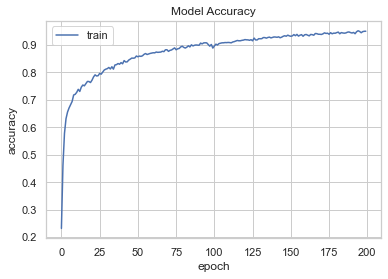

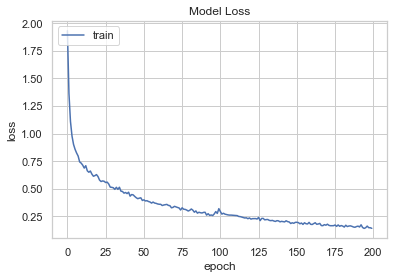

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            922624    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 92.305%


##### Confusion Matrix

12696 is the number of test value in kfold_val / train_test_split


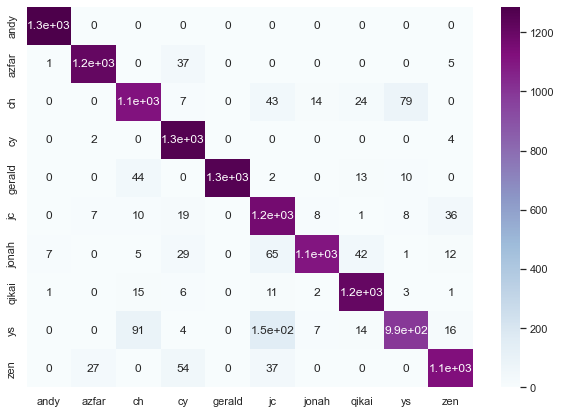

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

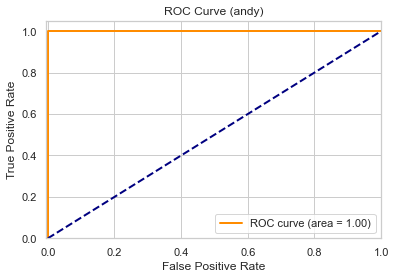

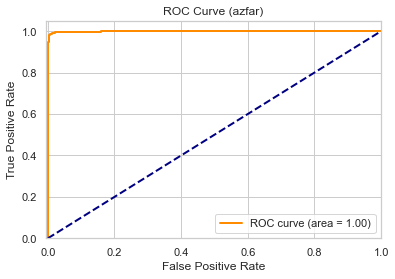

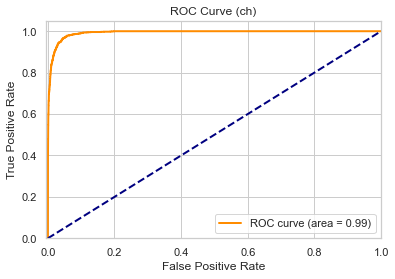

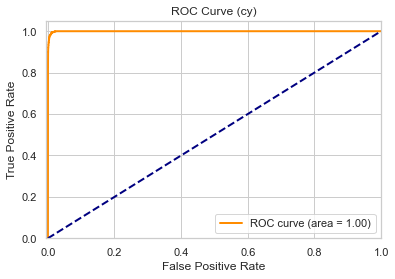

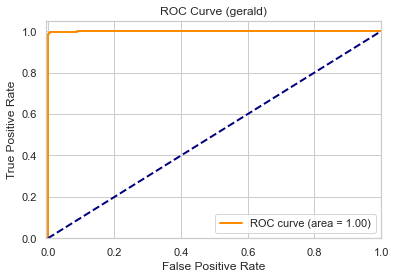

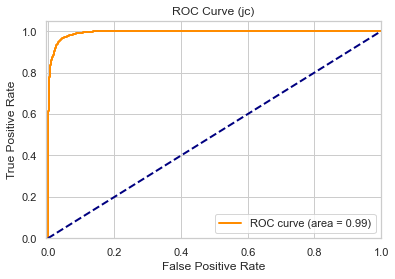

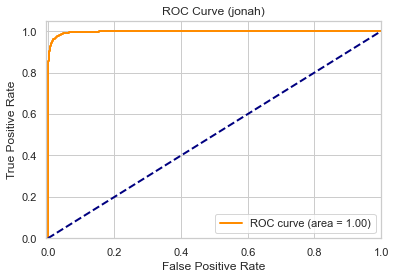

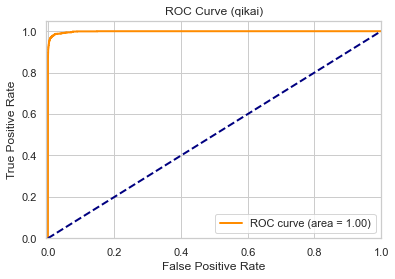

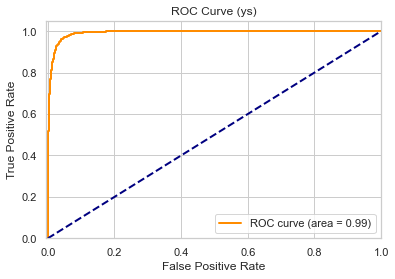

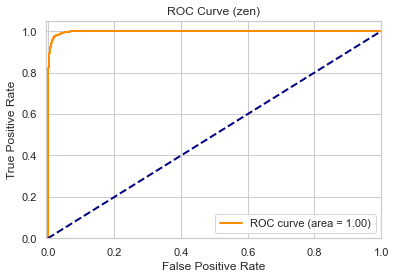

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

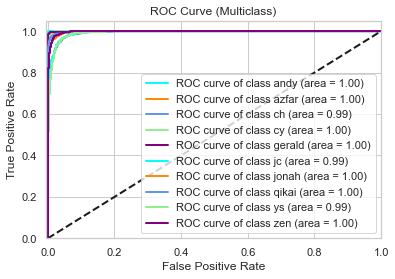

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

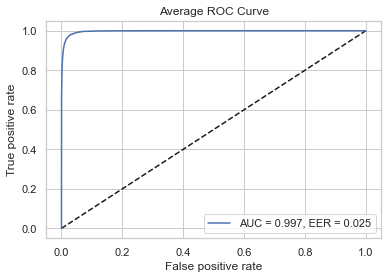

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (63480, 644)
Y | Classes  | Dataset Shape: (63480, 10)
There are a total of 10 classes.
Epoch 1/200
635/635 [==============================] - 31s 39ms/step - loss: 1.9372 - accuracy: 0.2590
Epoch 2/200
635/635 [==============================] - 25s 39ms/step - loss: 1.3018 - accuracy: 0.4863
Epoch 3/200
635/635 [==============================] - 25s 39ms/step - loss: 1.0250 - accuracy: 0.6100
Epoch 4/200
635/635 [==============================] - 25s 40ms/step - loss: 0.9120 - accuracy: 0.6542
Epoch 5/200
635/635 [==============================] - 25s 39ms/step - loss: 0.8527 - accuracy: 0.6739
Epoch 6/200
635/635 [==============================] - 25s 39ms/step - loss: 0.7988 - accuracy: 0.6972
Epoch 7/200
635/635 [==============================] - 25s 39ms/step - loss: 0.7500 - accuracy: 0.7160
Epoch 8/200
635/635 [==============================] -

635/635 [==============================] - 26s 41ms/step - loss: 0.2522 - accuracy: 0.9121
Epoch 78/200
635/635 [==============================] - 26s 41ms/step - loss: 0.2470 - accuracy: 0.9115
Epoch 79/200
635/635 [==============================] - 26s 42ms/step - loss: 0.2692 - accuracy: 0.9067
Epoch 80/200
635/635 [==============================] - 26s 41ms/step - loss: 0.2313 - accuracy: 0.9183
Epoch 81/200
635/635 [==============================] - 26s 41ms/step - loss: 0.2320 - accuracy: 0.9176
Epoch 82/200
635/635 [==============================] - 26s 42ms/step - loss: 0.2292 - accuracy: 0.9193
Epoch 83/200
635/635 [==============================] - 26s 42ms/step - loss: 0.2448 - accuracy: 0.9138
Epoch 84/200
635/635 [==============================] - 26s 42ms/step - loss: 0.2306 - accuracy: 0.9184
Epoch 85/200
635/635 [==============================] - 26s 42ms/step - loss: 0.2365 - accuracy: 0.9175
Epoch 86/200
635/635 [==============================] - 26s 41ms/step - loss:

635/635 [==============================] - 28s 43ms/step - loss: 0.1359 - accuracy: 0.9557
Epoch 156/200
635/635 [==============================] - 27s 43ms/step - loss: 0.1466 - accuracy: 0.9506
Epoch 157/200
635/635 [==============================] - 27s 43ms/step - loss: 0.1282 - accuracy: 0.9577
Epoch 158/200
635/635 [==============================] - 28s 44ms/step - loss: 0.1325 - accuracy: 0.9557
Epoch 159/200
635/635 [==============================] - 28s 44ms/step - loss: 0.1673 - accuracy: 0.9447
Epoch 160/200
635/635 [==============================] - 28s 44ms/step - loss: 0.1352 - accuracy: 0.9544
Epoch 161/200
635/635 [==============================] - 28s 44ms/step - loss: 0.1322 - accuracy: 0.9566
Epoch 162/200
635/635 [==============================] - 28s 44ms/step - loss: 0.1372 - accuracy: 0.9553
Epoch 163/200
635/635 [==============================] - 28s 44ms/step - loss: 0.1472 - accuracy: 0.9519
Epoch 164/200
635/635 [==============================] - 28s 44ms/ste

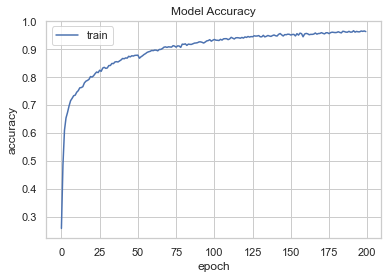

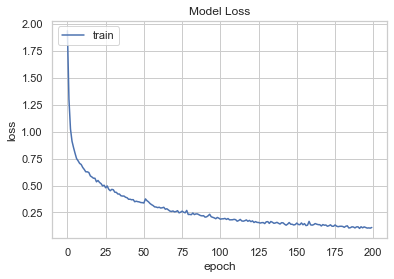

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR.1,T9-NG|VAR.1,T9-I|SD.1,T9-PF|SD.1,T9-RF|SD.1,T9-NG|SD.1,T10-I|0+9.1,T10-PF|0+9.1,T10-RF|0+9.1,T10-NG|0+9.1
0,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.000040,0.000103,0.002687,0.001119,0.006321,0.010128,1.022713,1.199032,1.199656,1.375975
1,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.010145,0.008453,0.077343,0.068562,0.100724,0.091942,0.708511,0.823514,0.887639,1.002642
2,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.001819,0.003063,0.066153,0.078847,0.042655,0.055349,0.674672,0.829957,0.804220,0.959506
3,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.005348,0.008820,0.067350,0.088133,0.073132,0.093915,1.032329,1.207123,1.203380,1.378173
4,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.003408,0.000581,0.058742,0.024466,0.058379,0.024103,0.887826,1.028076,1.016688,1.156938


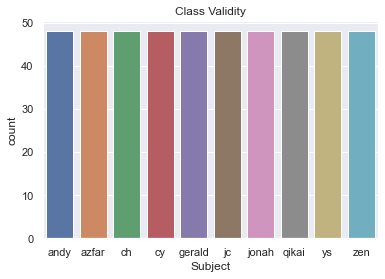

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'ch', 'cy', 'gerald', 'jc', 'jonah', 'qikai', 'ys', 'zen']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model: " + str(match_header))

Accuracy of the Model: 271/480 (56.458333333333336%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 05:56:08
